# Лекция 8. Разреженные матрицы и прямые методы для решения больших разреженных систем

## План на сегодняшнюю лекцию

- Разреженные матрицы и форматы их представления
- Быстрая реализация умножения разреженной матрицы на вектор 
- Метод Гаусса для разреженных матриц: упорядоченность
- Заполнение и графы: сепараторы
- Лапласиан графа

## Разреженные матрицы

- Ограничением в решении задач линейной алгебры с плотными матрицами является память, требуемая для хранения плотных матриц, $N^2$ элементов.

- Разреженные матрицы, где большинство элементов нулевые позволяют по крайней мере хранить их в памяти.

- Основные вопросы: можем ли мы решать следующие задачи для разреженных матриц?
    - решение линейных систем
    - вычисление собственных значений и собственных векторов
    - вычисление матричных функций

## Приложения разреженных матриц

Разреженные матрицы возникают в следующих областях:

- математическое моделирование и решение уравнений в частных производных
- обработка графов, например анализ социальных сетей
- рекомендательные системы
- в целом там, где отношения между объектами "разрежены".

### Разреженные матрицы помогают в вычислительной теории графов 

- Графы представляют в виде матриц смежности, которые чаще всего разрежены
- Численное решение задач теории графов сводится к операциям с этими разреженными матрицами
    - Кластеризация графа и выделение сообществ
    - Ранжирование
    - Случайные блуждатели
    - И другие....
- Пример: возможно, самый большой доступный граф гиперссылок содержит 3.5 миллиарда веб-страниц и 128 миллиардов гиперссылок, больше подробностей см. [тут](http://webdatacommons.org/hyperlinkgraph/) 
- Различные графы среднего размера для тестирования ваших алгоритмов доступны в [Stanford Large Network Dataset Collection](https://snap.stanford.edu/data/)

### Florida sparse matrix collection

- Большое количество разреженных матриц из различных приложений вы можете найти в [Florida sparse matrix collection](http://www.cise.ufl.edu/research/sparse/matrices/).

In [18]:
from IPython.display import IFrame
IFrame('http://yifanhu.net/GALLERY/GRAPHS/search.html', 500, 500)

### Разреженные матрицы и глубокое обучение

- DNN имеют очень много параметров
- Некоторые из них могут быть избыточными
- Как уменьшить число параметров без серьёзной потери в точности?
- [Sparse variational dropout method](https://github.com/ars-ashuha/variational-dropout-sparsifies-dnn) даёт существенно разреженные фильтры в DNN почти без потери точности!
- [Lottery ticket hypothesis](https://arxiv.org/pdf/1803.03635.pdf) также рассматривает возможность спрасификации нейросети без снижения точности прогноза

## Построение разреженных матриц

- Мы можем генерировать разреженные матрицы с помощью пакета ```scipy.sparse```

- Можно задать матрицы очень большого размера

Полезные функции при создании разреженных матриц:
- для созданий диагональной матрицы с заданными диагоналями ```spdiags```
- Кронекерово произведение (определение будет далее) разреженных матриц ```kron```
- также арифметические операции для разреженных матриц перегружены

### Кронекерово произведение

Для матриц $A\in\mathbb{R}^{n\times m}$ и $B\in\mathbb{R}^{l\times k}$ Кронекерово произведение определяется как блочная матрица следующего вида

$$
   A\otimes B = \begin{bmatrix}a_{11}B & \dots & a_{1m}B \\ \vdots & \ddots & \vdots \\ a_{n1}B & \dots & a_{nm}B\end{bmatrix}\in\mathbb{R}^{nl\times mk}.
$$

Основные свойства:
- билинейность
- $(A\otimes B) (C\otimes D) = AC \otimes BD$
- Пусть $\mathrm{vec}(X)$ оператор векторизации матрицы по столбцам. Тогда 
$\mathrm{vec}(AXB) = (B^T \otimes A) \mathrm{vec}(X).$

4992 1048576


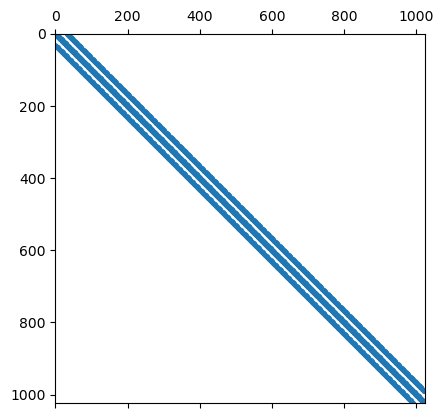

In [21]:
import numpy as np
import scipy as sp
import scipy.sparse
from scipy.sparse import csc_matrix, csr_matrix
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.sparse.linalg
%matplotlib inline
n = 32
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csc_matrix(A)
plt.spy(A, aspect='equal', marker='.', markersize=5)
print(A.nnz, np.prod(A.shape))

### Шаблон разреженности

- Команда ```spy``` рисует шаблон разреженности данной матрицы: пиксель $(i, j)$ отображается на рисунке, если соответствующий элемент матрицы ненулевой.

- Шаблон разреженности действительно очень важен для понимания сложности алгоритмов линейной алгебры для разреженных матриц.  

- Зачастую шаблона разреженности достаточно для анализа того, насколько "сложно" работать с этой матрицей.

### Определение разреженных матриц

- Разреженные матрицы – это матрицы, такие что количество ненулевых элементов в них существенно меньше общего числа элементов в матрице. 

- Из-за этого вы можете выполнять базовые операции линейной алгебры (прежде всего решать линейные системы) гораздо быстрее по сравнению с использованием плотных матриц.

## Что нам необходимо, чтобы увидеть, как это работает

- **Вопрос 1:** Как хранить разреженные матрицы в памяти?

- **Вопрос 2:** Как умножить разреженную матрицу на вектор быстро?

- **Вопрос 3:** Как быстро решать линейные системы с разреженными матрицами?

### Хранение разреженных матриц

Существет много форматов хранения разреженных матриц, наиболее важные:

- COO (координатный формат)
- LIL (список списков)
- CSR (compressed sparse row)
- CSC (compressed sparse column)
- блочные варианты

В ```scipy``` представлены конструкторы для каждого из этих форматов, например

```scipy.sparse.lil_matrix(A)```.

#### Координатный формат (COO)

- Простейший формат хранения разреженной матрицы – координатный. 
- В этом формате разреженная матрица – это набор индексов и значений в этих индексах.

```python
i, j, val
```

где ```i, j``` массивы индексов, ```val``` массив элементов матрицы. <br>

- Таким образом, нам нужно хранить $3\cdot$**nnz** элементов, где **nnz** обозначает число ненулевых элементов в матрице.

**Q:** Что хорошего и что плохого в использовании такого формата?

#### Основные недостатки

- Он неоптимален по памяти (почему?)
- Он неоптимален для умножения матрицы на вектор (почему?)
- Он неоптимален для удаления элемента (почему?)

Первые два недостатка решены в формате CSR.

#### Compressed sparse row (CSR)

В формате CSR матрица хранится также с помощью трёх массивов, но других:

```python
ia, ja, sa
```

где:

- **ia** (начало строк) массив целых чисел длины $n+1$ 
- **ja** (индексы столбцов) массив целых чисел длины **nnz** 
-  **sa** (элементы матрицы) массив действительных чисел длины **nnz**

<img src="https://www.karlrupp.net/wp-content/uploads/2016/02/csr_storage_sparse_marix.png" width=60% />

Итак, всего необходимо хранить $2\cdot{\bf nnz} + n+1$ элементов.

### Разреженные матрицы в PyTorch, Tensorflow и JAX

- PyTorch поддерживает разреженные матрицы в формате COO
- Неполная поддержка вычисления градиентов в операциях с такими матрицами, список и обсуждение см. [тут](https://github.com/pytorch/pytorch/issues/9674)
- Tensorflow также поддерживает разреженные матрицы в COO формате
- Список поддерживаемых операций приведён [здесь](https://www.tensorflow.org/api_docs/python/tf/sparse), поддержка вычисления градиентов ограничена
- JAX также [экспериментально поддерживает](https://jax.readthedocs.io/en/latest/jax.experimental.sparse.html) некоторые разреженные операции для COO матриц

### CSR формат позволяет быстро умножить разреженную матрицу на вектор (SpMV)

```python

   for i in range(n):
        
        for k in range(ia[i]:ia[i+1]):
            
            y[i] += sa[k] * x[ja[k]]
```

In [3]:
import numpy as np
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
from scipy.sparse import csc_matrix, csr_matrix, coo_matrix
import matplotlib.pyplot as plt
%matplotlib inline
n = 5000
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csr_matrix(A)
# Anp = A.toarray()
rhs = np.random.randn(n * n)
B = coo_matrix(A)
%timeit A @ rhs
%timeit B @ rhs
# %timeit Anp @ rhs

103 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
598 ms ± 4.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Видно, что **CSR** быстрее, и чем менее структурирован шаблон разреженности, тем выше выигрыш в скорости.

### Разреженные матрицы и эффективность

- Использование разреженных матриц приводит к уменьшению сложности
- Но они не очень подходят для параллельных/GPU реализаций 
- Они не показывают максимальную эффективность из-за случайного доступа к данным.   

### Случайный доступ к данным и промахи в обращении к кешу

- Сначала все элементы матрицы и вектора хранятся в оперативной памяти (RAM – Random Access Memory)
- После этого CPU берёт данные из кеша, обрабатывает их и возвращает результат снова в кеш
- Если CPU требуются данные, которых ещё нет в кеше, это называется промах в обращении к кешу (cache miss)
- Если случается промах в обращении к кешу, необходимые данные перемещаются из оперативной памяти в кеш

**Q**: что если в кеше нет свободного места?


- Чем больше промахов в обращении к кешу, тем медленнее выполняются вычисления

#### Умножение матрицы в CSR формате на вектор

```python

   for i in range(n):
        
        for k in range(ia[i]:ia[i+1]):
            
            y[i] += sa[k] * x[ja[k]]
            
```

- Какая часть операций приводит к промахам в обращении к кешу?
- Как эту проблему можно решить?

### Переупорядочивание уменьшает количество промахов в обращении к кешу

- Если ```ja``` хранит последовательно элементы, тогда они могут быть перемещены в кеш одновременно и количество промахов в обращении к кешу уменьшится
- Так происходит, когда разреженная матрица является **ленточной** или хотя бы блочно-диагональной
- Мы можем превратить данную разреженную матрицу в ленточную или блочно-диагональную с помощью *перестановок* 

- Пусть $P$ матрица перестановок строк матрицы и $Q$ матрица перестановок столбцов матрицы
- $A_1 = PAQ$ – матрица с шириной ленты меньшей, чем у матрицы $A$
- $y = Ax \to \tilde{y} = A_1 \tilde{x}$, где $\tilde{x} = Q^{\top}x$ и $\tilde{y} = Py$
- [Separated block diagonal form](http://albert-jan.yzelman.net/PDFs/yzelman09-rev.pdf) призван минимизировать количество промахов в обращении к кешу
- Он также может быть расширен на двумерный случай, где разделяются не только строки, но и столбцы

## Методы решения линейных систем с разреженными матрицами

- Прямые методы
    - LU разложение
    - Различные методы переупорядочивания для минимизации заполнения факторов
- Крыловские методы

35.3 ms ± 4.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.16 s ± 51.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


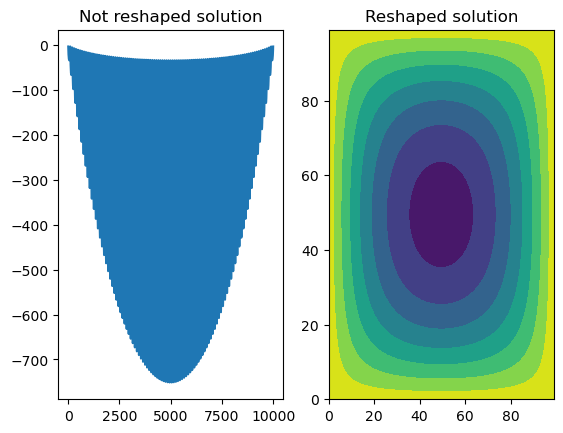

In [7]:
n = 100
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csr_matrix(A)
rhs = np.ones(n * n)
sol = sp.sparse.linalg.spsolve(A, rhs)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(sol)
ax1.set_title('Not reshaped solution')
ax2.contourf(sol.reshape((n, n), order='f'))
ax2.set_title('Reshaped solution')

Anp = A.toarray()
%timeit sp.sparse.linalg.spsolve(A, rhs)
%timeit np.linalg.solve(Anp, rhs)

## LU разложение разреженной матрицы

- Почему разреженная линейная система может быть решена быстрее, чем плотная? С помощью какого метода? 

- В LU разложении матрицы $A$ факторы $L$ и $U$ могут быть также разреженными:

$$A = L U$$

- А решение линейной системы с разреженной треугольной матрицей может быть вычислено очень быстро.  

<font color='red'> Заметим, что обратная матрица от разреженной матрицы НЕ разрежена! </font>


In [8]:
n = 7
ex = np.ones(n);
a = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
b = np.array(np.linalg.inv(a.toarray()))
print(a.toarray())
print(b)

[[-2.  1.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  1. -2.]]
[[-0.875 -0.75  -0.625 -0.5   -0.375 -0.25  -0.125]
 [-0.75  -1.5   -1.25  -1.    -0.75  -0.5   -0.25 ]
 [-0.625 -1.25  -1.875 -1.5   -1.125 -0.75  -0.375]
 [-0.5   -1.    -1.5   -2.    -1.5   -1.    -0.5  ]
 [-0.375 -0.75  -1.125 -1.5   -1.875 -1.25  -0.625]
 [-0.25  -0.5   -0.75  -1.    -1.25  -1.5   -0.75 ]
 [-0.125 -0.25  -0.375 -0.5   -0.625 -0.75  -0.875]]


## А факторы...

- $L$ и $U$ обычно разрежены
- В случае трёхдиагональной матрицы они даже бидиагональны!

[0 1 2 3 4 5 6] [0 1 2 3 4 5 6]


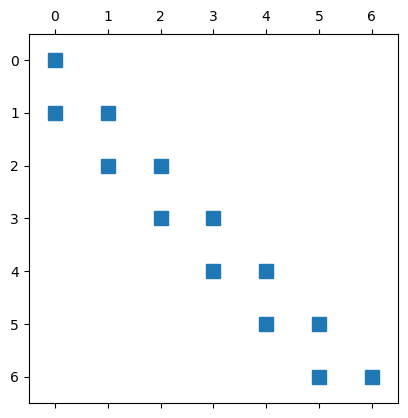

In [13]:
from scipy.sparse.linalg import splu
T = splu(a.tocsc(), permc_spec="NATURAL")
plt.spy(T.L)
print(T.perm_r, T.perm_c)

Отметим, что ```splu``` со значением параметра ```permc_spec``` по умолчанию даёт перестановку, которая не даёт бидиагональные факторы:

[0 1 2 3 5 4 6] [0 1 2 3 5 4 6]


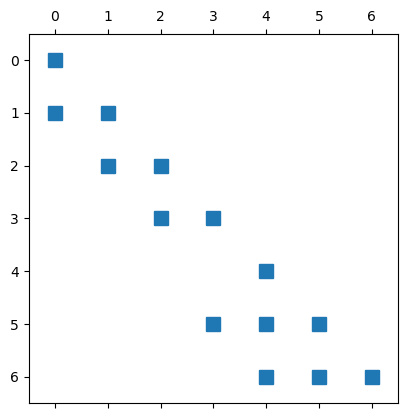

In [14]:
from scipy.sparse.linalg import splu
T = splu(a.tocsc())
plt.spy(T.L)
print(T.perm_c, T.perm_r)

## Двумерный случай

В двумерном случае всё гораздо хуже:

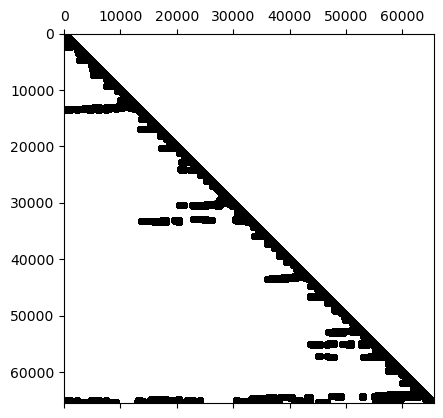

In [21]:
n = 256
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csc_matrix(A)
T = scipy.sparse.linalg.splu(A)
plt.spy(T.L, marker='.', color='k', markersize=8)

Для правильной перестановки в двумерном случае число ненулевых элементов в $L$ растёт как $\mathcal{O}(N \log N)$. Однако сложность равна $\mathcal{O}(N^{3/2})$.

## Разреженные матрицы и теория графов

- Число ненулей в факторах из LU разложения тесно связано с теорией графов.

- Пакет ``networkx`` можно использовать для визуализации графов, имея только матрицу смежности. 

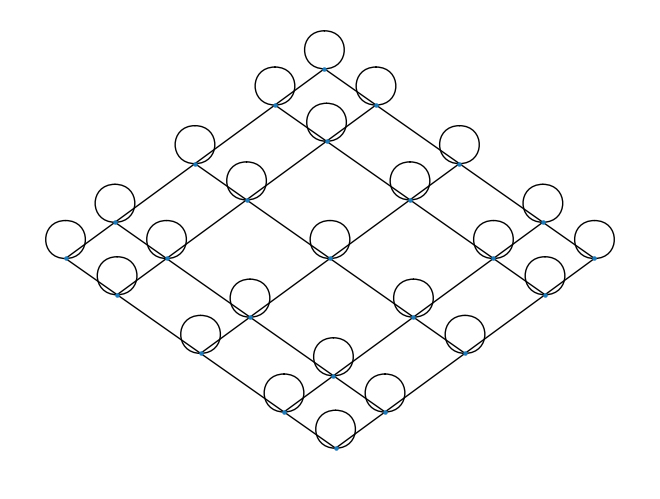

In [22]:
import networkx as nx
n = 5
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csc_matrix(A)
G = nx.Graph(A)
nx.draw(G, pos=nx.spectral_layout(G), node_size=5)

## Заполнение (fill-in)

- Заполнение матрицы – это элементы, которые были **нулями**, но стали **ненулями** в процессе выполнения алгоритма.

- Заполнение может быть различным для различных перестановок. Итак, до того как делать факторизацию матрицы нам необходимо переупорядочить её элементы так, чтобы заполнение факторов было наименьшим.

**Пример**

$$A = \begin{bmatrix} * & * & * & * & *\\ * & * & 0 & 0 & 0 \\ * & 0  & * & 0 & 0 \\ * & 0 & 0& * & 0 \\ * & 0 & 0& 0 & * \end{bmatrix} $$

- Если мы исключаем элементы сверху вниз, тогда мы получим плотную матрицу.
- Однако мы можем сохранить разреженность, если исключение будет проводиться снизу вверх.
- Подробности на следующих слайдах

## Метод Гаусса для разреженных матриц

- Дана матрица $A$ такая что $A=A^*>0$. 
- Вычислим её разложение Холецкого $A = LL^*$.

Фактор $L$ может быть плотным даже если $A$ разреженная:

$$
\begin{bmatrix} * & * & * & * \\ * & * &  &  \\ * &  & * &  \\ * &  &  & * \end{bmatrix} = 
\begin{bmatrix} * &  &  &  \\ * & * &  &  \\ * & * & * &  \\ * & * & * & * \end{bmatrix}
\begin{bmatrix} * & * & * & * \\  & * & * & * \\  &  & * & * \\  &  &  & * \end{bmatrix}
$$

**Q**: как сделать факторы разреженными, то есть минимизировать заполнение?

## Метод Гаусса и перестановка

- Нам нужно найти перестановку индексов такую что факторы будут разреженными, то есть мы будем вычислять разложение Холецкого для матрицы $PAP^\top$, где $P$ – матрица перестановки.

- Для примера с предыдущего слайда

$$
P \begin{bmatrix} * & * & * & * \\ * & * &  &  \\ * &  & * &  \\ * &  &  & * \end{bmatrix} P^\top = 
\begin{bmatrix} * &  &  & *  \\  & * &  & * \\  &  & * & * \\ * & * & * & * \end{bmatrix} = 
\begin{bmatrix} * &  &  &  \\  & * &  &  \\  &  & * &  \\ * & * & * & * \end{bmatrix}
\begin{bmatrix} * &  &  & *  \\  & * &  & * \\  &  & * & * \\  & &  & * \end{bmatrix}
$$

где

$$
P = \begin{bmatrix}  &  &  & 1 \\  &  & 1 &  \\  & 1 &  &  \\ 1 &  &  &  \end{bmatrix}
$$

- Такая форма матрицы даёт разреженные факторы в LU разложении

Original matrix


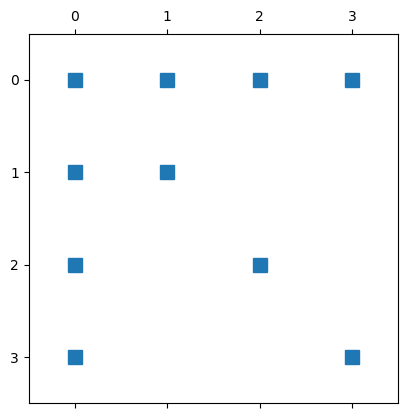

L factor


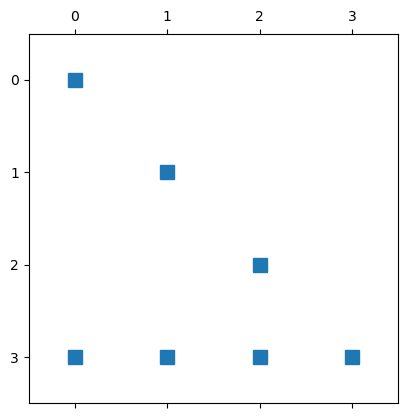

U factor


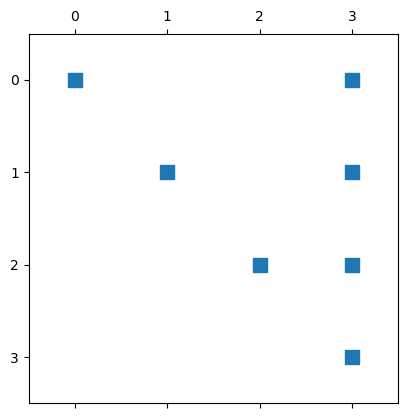

Column permutation: [3 0 1 2]
Row permutation: [3 0 1 2]


In [24]:
import numpy as np
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplin
import scipy.linalg as splin
import matplotlib.pyplot as plt
%matplotlib inline

A = spsp.coo_matrix((np.random.randn(10), ([0, 0, 0, 0, 1, 1, 2, 2, 3, 3], 
                                           [0, 1, 2, 3, 0, 1, 0, 2, 0, 3])))
print("Original matrix")
plt.spy(A)
plt.show()
lu = spsplin.splu(A.tocsc())
print("L factor")
plt.spy(lu.L)
plt.show()
print("U factor")
plt.spy(lu.U)
plt.show()
print("Column permutation:", lu.perm_c)
print("Row permutation:", lu.perm_r)

### Блочный случай

$$
PAP^\top = \begin{bmatrix} A_{11} &  & A_{13} \\  & A_{22} & A_{23} \\ A_{31} & A_{32} & A_{33}\end{bmatrix}
$$

тогда

$$
PAP^\top = \begin{bmatrix} A_{11} & 0 & 0 \\ 0 & A_{22} & 0 \\ A_{31} & A_{32} & A_{33} - A_{31}A_{11}^{-1} A_{13} - A_{32}A_{22}^{-1}A_{23} \end{bmatrix} \begin{bmatrix}  I & 0 & A_{11}^{-1}A_{13} \\ 0 & I & A_{22}^{-1}A_{23} \\ 0 & 0 & I\end{bmatrix}
$$

- Блок $ A_{33} - A_{31}A_{11}^{-1} A_{13} - A_{32}A_{22}^{-1}A_{23}$ является дополнением по Шуру для блочно-диагональной матрицы $\begin{bmatrix} A_{11} & 0 \\ 0 & A_{22} \end{bmatrix}$
- Мы свели задачу к решению меньших линейных систем с матрицами $A_{11}$ и $A_{22}$ 

### Как найти перестановку?

- Основная идея взята из теории графов
- Разреженную матрицы можно рассматривать как **матрицу смежности** некоторого графа: вершины $(i, j)$ связаны ребром, если соответствующий элемент матрицы не ноль.


### Пример

Графы для матрицы $\begin{bmatrix} * & * & * & * \\ * & * &  &  \\ * &  & * &  \\ * &  &  & * \end{bmatrix}$ и для матрицы $\begin{bmatrix} * &  &  & *  \\  & * &  & * \\  &  & * & * \\ * & * & * & * \end{bmatrix}$ имеют следующий вид:

<img src="./graph_dense.png" width=300 align="center"> и <img src="./graph_sparse.png" width=300 align="center">

* Почему вторая упорядоченность лучше, чем первая?

### Сепаратор графа

**Определение.** Сепаратором графа $G$ называется множество вершин $S$, таких что их удаление оставляет как минимум две связные компоненты.

Сепаратор $S$ даёт следующий метод нумерации вершин графа $G$:
- Найти сепаратор $S$, удаление которого оставляет связные компоненты $T_1$, $T_2$, $\ldots$, $T_k$
- Номера вершин в $S$ от $N − |S| + 1$ до $N$
- Рекурсивно, номера вершин в каждой компоненте: 
    - в $T_1$ от $1$ до $|T_1|$
    - в $T_2$ от $|T_1| + 1$ до $|T_1| + |T_2|$
    - и так далее
- Если компонента достаточно мала, то нумерация внутри этой компоненты произвольная

### Сепаратор и структура матрицы: пример

Сепаратор для матрицы двумерного лапласиана

$$
 A_{2D} = I \otimes A_{1D} + A_{1D} \otimes I, \quad A_{1D} = \mathrm{tridiag}(-1, 2, -1),
$$

имеет следующий вид

<img src='./separator.png' width=300> </img>

Если мы пронумеруем сначала индексы в $\alpha$, затем в $\beta$, и наконец индексы в сепараторе $\sigma$ получим следующую матрицу

$$
PAP^\top = \begin{bmatrix} A_{\alpha\alpha} &  & A_{\alpha\sigma} \\  & A_{\beta\beta} & A_{\beta\sigma} \\ A_{\sigma\alpha} & A_{\sigma\beta} & A_{\sigma\sigma}\end{bmatrix},
$$

которая имеет подходящую структуру.

- Таким образом, задача поиска перестановки была сведена к задаче поиска сепаратора графа!

### Nested dissection

- Для блоков $A_{\alpha\alpha}$, $A_{\beta\beta}$ можем продолжить разбиение рекурсивно

- После завершения рекурсии нужно исключить блоки $A_{\sigma\alpha}$ и $A_{\sigma\beta}$. 

- Это делает блок в положении $A_{\sigma\sigma}\in\mathbb{R}^{n\times n}$ **плотным**.

- Вычисление разложения Холецкого этого блока стоит $\mathcal{O}(n^3) = \mathcal{O}(N^{3/2})$, где $N = n^2$ – общее число вершин.

- В итоге сложность $\mathcal{O}(N^{3/2})$

## Пакеты для nested dissection

- MUltifrontal Massively Parallel sparse direct Solver ([MUMPS](http://mumps.enseeiht.fr/))
- [Pardiso](https://www.pardiso-project.org/)
- [Umfpack как часть пакета SuiteSparse](http://faculty.cse.tamu.edu/davis/suitesparse.html)

У них есть интефейс для C/C++, Fortran и Matlab 

### Резюме про nested dissection

- Нумерация свелась к поиску сепаратора
- Подход разделяй и властвуй
- Рекурсивно продолжается на два (или более) подмножества вершин после разделения
- В теории nested dissection даёт оптимальную сложность (почему?)
- На практике этот метод лучше других только на очень больших задачах

## Сепараторы на практике

- Вычисление сепаратора – это **нетривиальная задача!**

- Построение методов разбиения графа было активной сферой научных исследований долгие годы

Существующие подходы:

- Спектральное разбиение (использует собственные векторы **Лапласиана графа**) – подробности далее
- Геометрическое разбиение (для сеток с заданными координатами вершин) [обзор и анализ](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.31.4886&rep=rep1&type=pdf)
- Итеративные перестановки ([(Kernighan-Lin, 1970)](http://xilinx.asia/_hdl/4/eda.ee.ucla.edu/EE201A-04Spring/kl.pdf), [(Fiduccia-Matheysses, 1982](https://dl.acm.org/citation.cfm?id=809204))
- Поиск в ширину [(Lipton, Tarjan 1979)](http://www.cs.princeton.edu/courses/archive/fall06/cos528/handouts/sepplanar.pdf)
- Многоуровневая рекурсивная бисекция (наиболее практичная эвристика) ([обзор](https://people.csail.mit.edu/jshun/6886-s18/lectures/lecture13-1.pdf) и [статья](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.499.4130&rep=rep1&type=pdf)). Пакет для подобного рода разбиений называется METIS, написан на C, и доступен [здесь](http://glaros.dtc.umn.edu/gkhome/views/metis)

## Спектральное разбиение графа

- Идея спектрального разбиения восходит к работам Мирослава Фидлера, который изучал связность графов ([статья](https://dml.cz/bitstream/handle/10338.dmlcz/101168/CzechMathJ_23-1973-2_11.pdf)).

- Нам нужно разбить вершинеы графа на 2 множества

- Рассмотрим метки вершин +1/-1 и **функцию потерь**

$$E_c(x) = \sum_{j} \sum_{i \in N(j)} (x_i - x_j)^2, \quad N(j) \text{ обозначает множество соседей вершины } j. $$

Нам нужно сбалансированное разбиение, поэтому

$$\sum_i x_i =  0 \quad \Longleftrightarrow \quad x^\top e = 0, \quad e = \begin{bmatrix}1 & \dots & 1\end{bmatrix}^\top,$$

и поскольку мы ввели метки +1/-1, то выполнено

$$\sum_i x^2_i = n \quad \Longleftrightarrow \quad \|x\|_2^2 = n.$$

## Лапласиан графа

Функция потерь $E_c$ может быть записана в виде (проверьте почему)

$$E_c = (Lx, x)$$

где $L$ – **Лапласиан графа**, который определяется как симметричная матрица с элементами

$$L_{ii} = \mbox{степень вершины $i$},$$

$$L_{ij} = -1, \quad \mbox{если $i \ne j$  и существует ребро},$$

и $0$ иначе.

- Строчные суммы в матрице $L$ равны нулю, поэтому существует собственное значение $0$, которое даёт собственный вектор из всех 1.
- Собственные значения неотрицательны (почему?).

## Разбиение как задача оптимизации

- Минимизация $E_c$ с упомянутыми ограничениями приводит к разбиению, которое минимизирует число вершин в сепараторе, но сохраняет разбиение сбалансированным

- Теперь мы запишем релаксацию целочисленной задачи квадратичного программирования в форме непрерывной задачи квадратичного программирования

$$E_c(x) = (Lx, x)\to \min_{\substack{x^\top e =0, \\ \|x\|_2^2 = n}}$$

## Вектор Фидлера

- Решение этой задачи минимизации – собственный вектор матрицы $L$, соответствующий **второму** минимальному собственному значению (он называется вектором Фидлера)
- В самом деле,

$$
    \min_{\substack{x^\top e =0, \\ \|x\|_2^2 = n}} (Lx, x) = n \cdot \min_{{x^\top e =0}} \frac{(Lx, x)}{(x, x)} = n \cdot \min_{{x^\top e =0}} R(x), \quad R(x) \text{ отношение Релея}
$$

- Поскольку $e$ – собственный вектор, соответствующий наименьшему собственному значению, то на подпространстве $x^\top e =0$ мы получим второе минимальное собственное значение.

- Знак $x_i$ обозначает разбиение графа.

- Осталось понять, как вычислить этот вектор. Мы знаем про степенной метод, но он ищет собственный вектор для максимального по модулю собственного значения.
- Итерационные методы для задачи на собственные значения будут рассмотрены далее в курсе...


Number of vertices = 34
Number of edges = 78


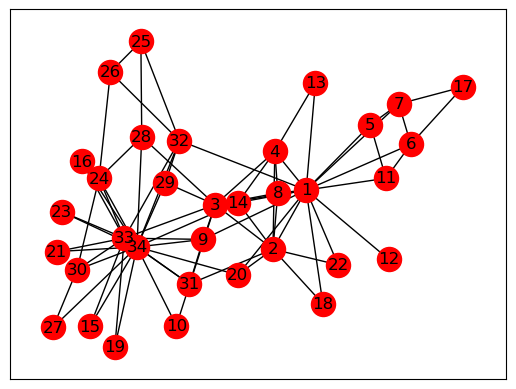

In [25]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
kn = nx.read_gml('karate.gml')
print("Number of vertices = {}".format(kn.number_of_nodes()))
print("Number of edges = {}".format(kn.number_of_edges()))
nx.draw_networkx(kn, node_color="red") #Draw the graph

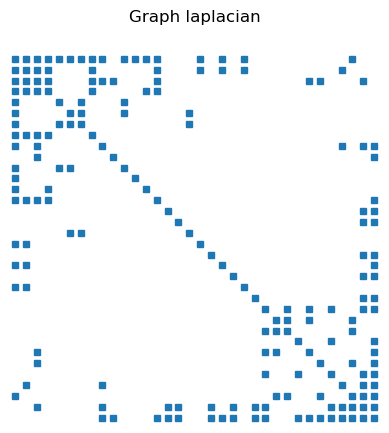

The 2 smallest eigenvalues = [-1.15426941e-15  4.68525227e-01]


In [26]:
Laplacian = nx.laplacian_matrix(kn).asfptype()
plt.spy(Laplacian, markersize=5)
plt.title("Graph laplacian")
plt.axis("off")
plt.show()
eigval, eigvec = spsplin.eigsh(Laplacian, k=2, which="SM")
print("The 2 smallest eigenvalues =", eigval)

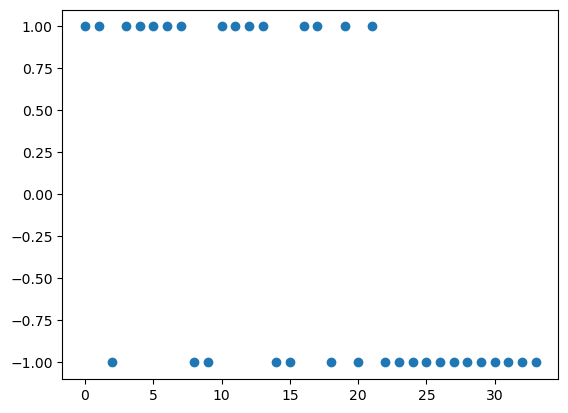

Sum of elements in Fiedler vector = 1.912359159916832e-14


In [27]:
plt.scatter(np.arange(len(eigvec[:, 1])), np.sign(eigvec[:, 1]))
plt.show()
print("Sum of elements in Fiedler vector = {}".format(np.sum(eigvec[:, 1].real)))

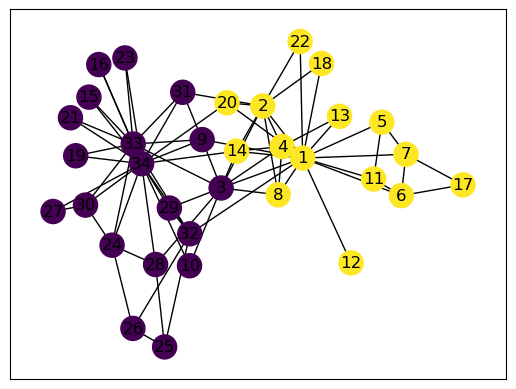

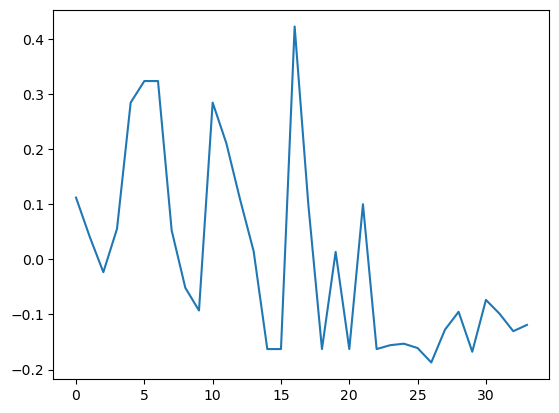

In [29]:
nx.draw_networkx(kn, node_color=np.sign(eigvec[:, 1]))
plt.show()
plt.figure()
plt.plot(eigvec[:, 1])

### Резюме по примеру использования спектрального разбиения графа

- Мы вызвали функцию из SciPy для поиска фиксированного числа собственных векторов и собственных значений, которые минимальны (возможны другие опции)
- Детали методов, которые реализованы в этих функциях, обсудим уже скоро
- Вектор Фидлера даёт простой способ разбиения графа
- Для разбиения графа на большее количество частей следует использовать собственные векторы Лапласиана как векторы признаков и запустить какой-нибудь алгоритм кластеризации, например $k$-means

### Вектор Фидлера и алгебраическая связность графа

**Определение.** Алгебраическая связность графа – это второе наименьшее собственное значение матрицы Лапласиана графа.

**Утверждение.** Алгебраическая связность графа больше 0 тогда и только тогда, когда граф связный.

## Minimal degree orderings

- Идея в том, чтобы исклоючить строки и/или столбцы с малым числом ненулей, обновить заполнение и повторить.

- Эффективная реализация является отдельной задачей (добавление/удаление элементов).

- На практике часто лучше всего для задач среднего размера

- SciPy [использует](https://docs.scipy.org/doc/scipy-1.3.0/reference/generated/scipy.sparse.linalg.splu.html) этот подход для различных матриц ($A^{\top}A$, $A + A^{\top}$) 

## Главное в сегодняшней лекции

- Разреженные матрицы, приложения и форматы их хранения
- Эффективные способы умножения разреженной матрицы на вектор
- LU разложение разреженной матрицы: заполнение и перестановки строк
- Минимизация заполнения: сепараторы и разбиение графа
- Nested dissection
- Спектральное разбиение графа: Лапласиан графа и вектор Фидлера